<a href="https://colab.research.google.com/github/chain-veerender/veerender/blob/master/AgenticAI_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Lets start with simple LLM AI Agent and fundamental structure**

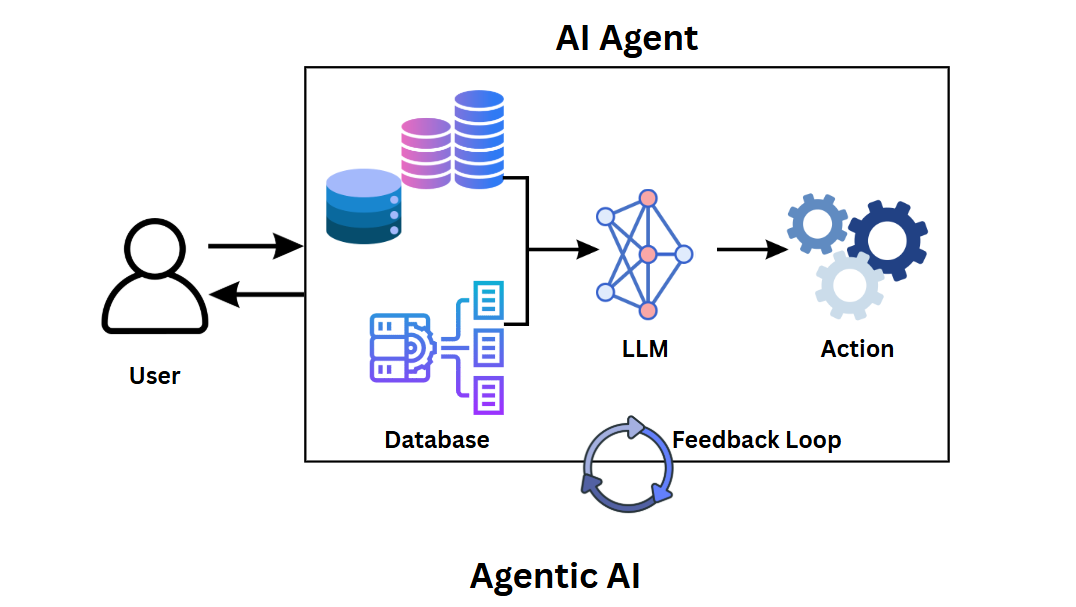

Image Credits: https://www.codecademy.com/article/agentic-ai-with-langchain-langgraph

In [1]:
!pip install openai

**Setup and LLM Integration**

In [6]:
import os
from openai import OpenAI
# Load API key from Colab Secrets
from google.colab import userdata
import os
## Replace here with your personal or enterprise openai secret key
OPENAI_API_KEY = userdata.get("veer_openai_key")
# Initialize the OpenAI client with your API key
client = OpenAI(api_key=OPENAI_API_KEY)


**Agents core logic**

In [9]:
class SimpleFactAgent:

      def simple_llm_call(prompt):
        try:
          response = client.chat.completions.create(
          model="gpt-4o-mini",
          messages=[
                {"role": "system", "content": "You are a helpful AI assistant."},
                {"role": "user", "content": prompt}
                  ],
          max_tokens=150,
          temperature=0.7,
          )
          return response.choices[0].message.content.strip()
        except Exception as e:
          return f"An error occurred: {e}"


**Agent Interaction**

In [10]:
if __name__ == "__main__":
    # Create an instance of the agent
    fact_agent = SimpleFactAgent

    while True:
        user_input = input("Ask a question (or type 'exit' to quit): ")
        if user_input.lower() == 'exit':
            break

        # Get the answer from the agent
        answer = fact_agent.simple_llm_call(user_input)
        print(f"Agent says: {answer}")

Ask a question (or type 'exit' to quit): what is capital of italy
Agent says: The capital of Italy is Rome.
Ask a question (or type 'exit' to quit): describe agents as class in programming
Agent says: In programming, especially in the context of object-oriented programming (OOP), the concept of "agents" can be modeled as a class. An agent can be thought of as an entity that can perceive its environment, make decisions based on its perceptions, and take actions to achieve its goals. 

Here’s a breakdown of how you might define an `Agent` class in programming:

### Basic Structure of an Agent Class

1. **Attributes**: These are properties that define the state of the agent. For example:
   - `id`: A unique identifier for the agent.
   - `location`: The current position of the agent in its environment.
   - `knowledge`: Information the agent has about the environment.
   - `goals`:
Ask a question (or type 'exit' to quit): exit


**AI Agents as Objects:**


An AI agent, in a programming context, can be conceptualized and implemented as an object.

This object encapsulates the agent's state (its internal data, beliefs, and goals) and its behavior (the actions it can perform and the decisions it makes).

For example, a customer support AI agent might be an object with attributes like customer_id, query_history, and methods like respond_to_query() or search_knowledge_base().

**Classes as foundation for AI Agents**

Classes serve as the blueprints or templates for creating these AI agent objects.

A class defines the common structure and behavior that all instances of a particular type of AI agent will share.

For instance, a LearningAgent class could define the attributes and methods common to all learning agents, such as learning_element, problem_generator, and refine_performance().

This allows for the creation of multiple AI agent instances, each with its own specific state, but all adhering to the defined structure and capabilities of the class.

**Benefits of Using Classes for AI Agents:**

**Modularity and Reusability:**
Classes promote modular design, allowing developers to create distinct, reusable components for different types of AI agents.

**Encapsulation:**
They encapsulate the internal workings of an agent, presenting a clear interface for interaction while hiding implementation details.

**Inheritance and Polymorphism:**
OOP features like inheritance allow for the creation of specialized AI agent types (e.g., a SimpleReflexAgent inheriting from a more general AIAgent class), while polymorphism enables agents of different types to be treated uniformly.

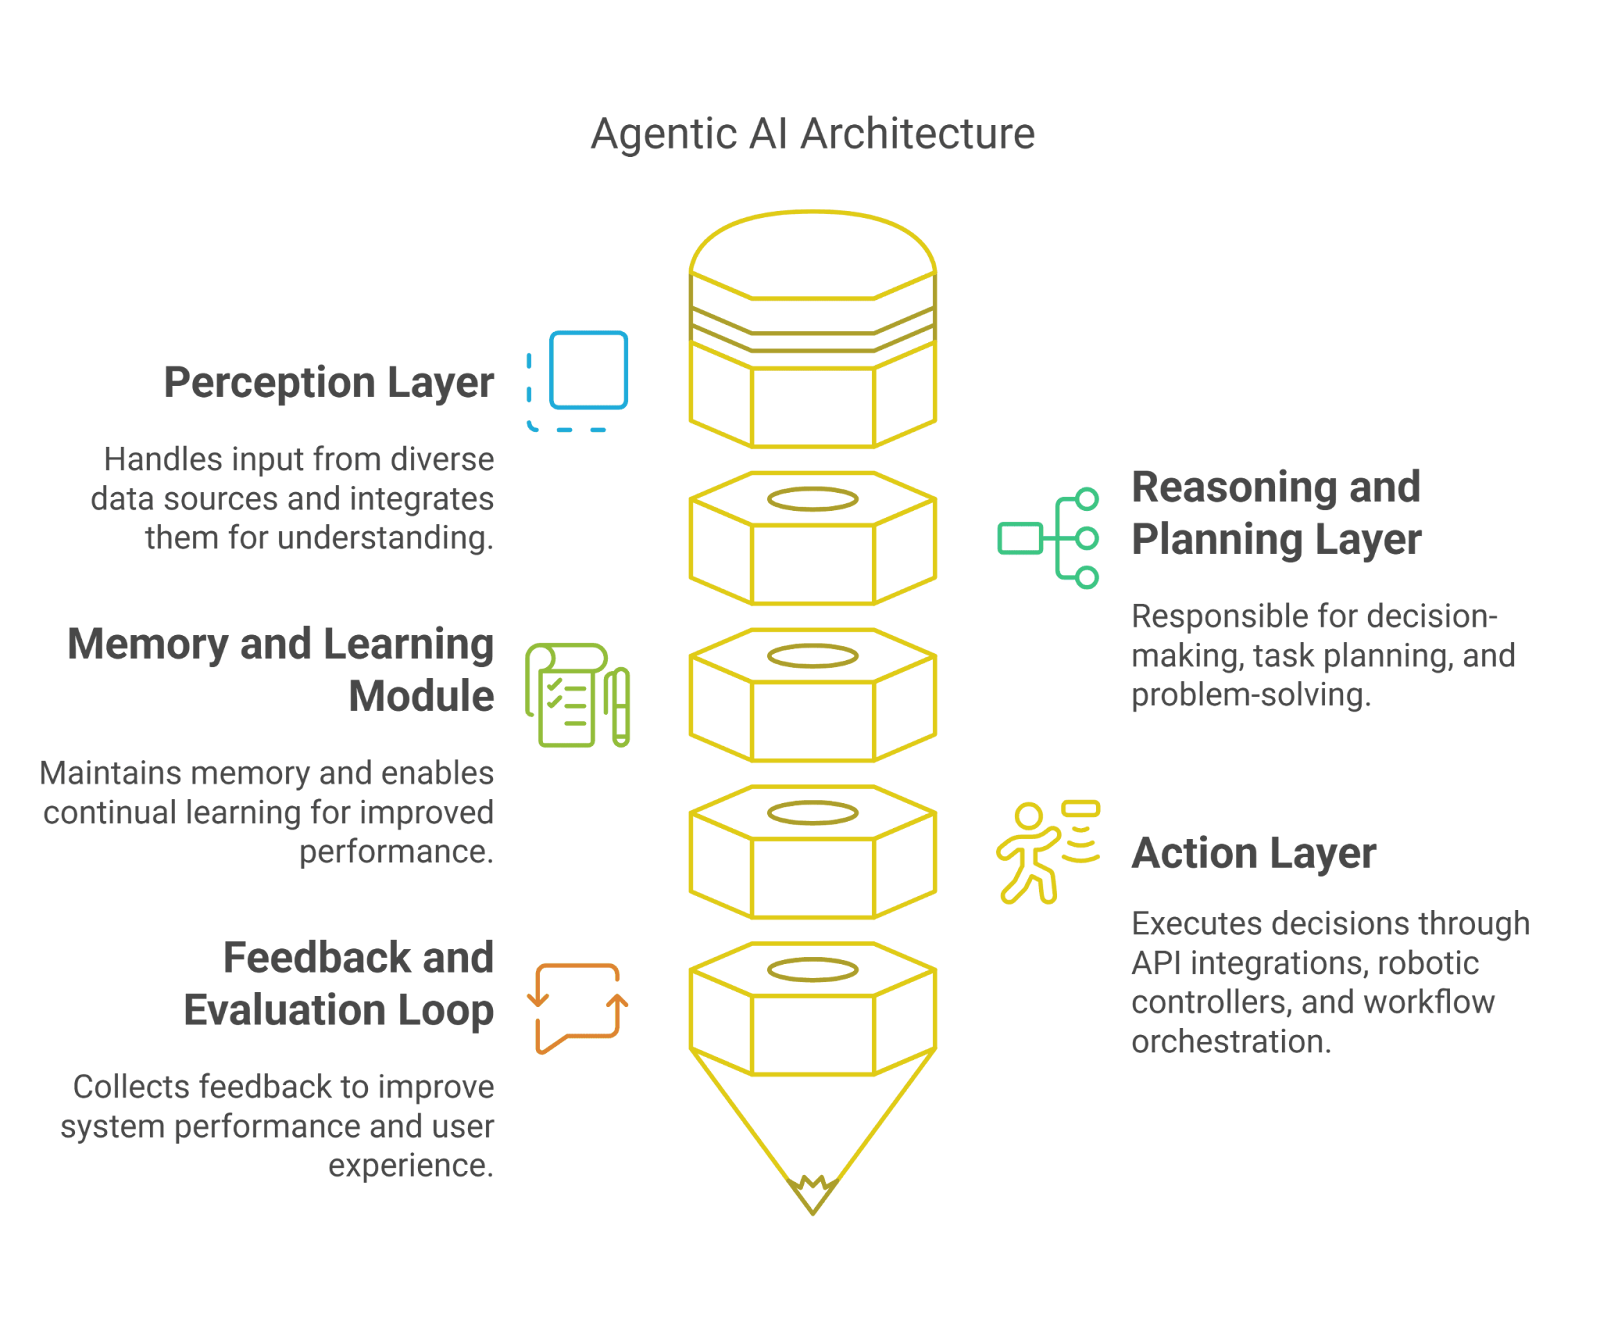

Image Credits: https://www.ema.co/additional-blogs/addition-blogs/future-of-agentic-ai-systems-opportunities-challenges-and-practical-guidelines

**Drill down - Interactive Learning in Agentic AI**

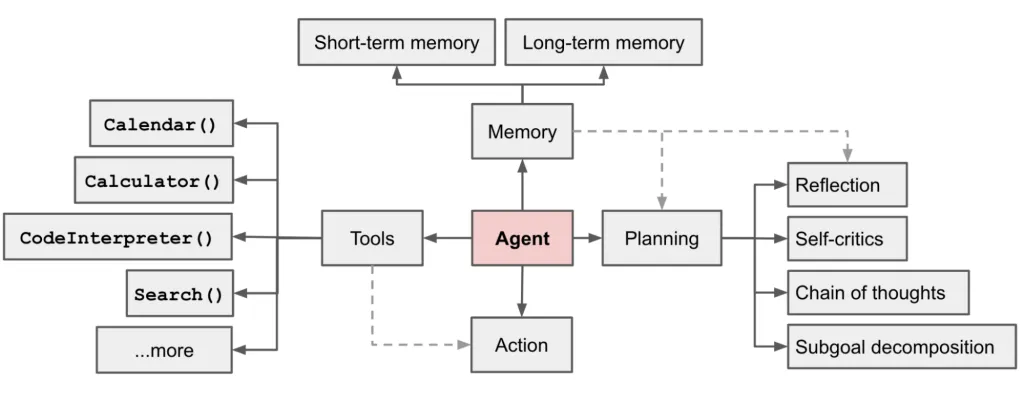

Image credits: https://helabenkhalfallah.com/2025/07/22/cognition-autonomy-and-interaction-in-agentic-ai-systems/

**Core Components of Agentic AI Architecture:**

**Perception:**
The ability to gather information from the environment (e.g., text, images, sensor data).

**Reasoning/Planning:**
The capacity to process perceived information, understand the context, formulate plans, and make decisions. This often involves LLMs.

**Action:**
The capability to execute the planned actions in the environment, which could involve interacting with other systems or generating text

**Memory:**
The ability to store and recall past experiences, observations, and learned knowledge to inform future decisions and actions.

**Learning/Reflection:**
The mechanism for the agent to refine its strategies, improve its performance, and adapt to new situations based on feedback and outcomes.

**Lets build customer support triage  Agent (Mock)**

**Process flow:**
kb(Knowledge base) search -> Route Ticket (production, issue type, severity) -> create ticket(title, description, customer, severity, product, labels):mock JSON ticket -> notify_pager(severity, message): mock escalation log

**Agent outcome expectation:** once we feed a payments-outage email -->  agent will search memory/KB, route, create a ticket, (optionally) escalate, and draft a customer reply.

In [1]:
from __future__ import annotations


import os
import json
import time
import math
import base64
import sqlite3
import threading
from dataclasses import dataclass, field
from typing import Any, Dict, List, Callable, Optional, Tuple


import numpy as np
from openai import OpenAI

In [12]:
# ------------------------------
# Configuration
# ------------------------------
OPENAI_MODEL = os.getenv("OPENAI_MODEL", "gpt-4o")
EMBED_MODEL = os.getenv("OPENAI_EMBED_MODEL", "text-embedding-3-small")
DB_PATH = os.getenv("AGENT_MEMORY_DB", "agent_memory.db")


#client = OpenAI()  ## Not required already executed in first cell setup and LLM


# ------------------------------
# Utility: embeddings & similarity
# ------------------------------
def embed_text(text: str) -> List[float]:
  """Get an embedding vector for text."""
  # You can cache these in production.
  resp = client.embeddings.create(model=EMBED_MODEL, input=text)
  return resp.data[0].embedding




def cosine_sim(a: np.ndarray, b: np.ndarray) -> float:
  denom = (np.linalg.norm(a) * np.linalg.norm(b))
  if denom == 0:
    return 0.0
  return float(np.dot(a, b) / denom)

In [15]:
# ------------------------------
# Memory: SQLite + vectors
# ------------------------------
class VectorMemory:
    """Simple vector-ish memory with SQLite backing and cosine similarity search."""

    def __init__(self, path: str = DB_PATH):
        self.path = path
        self._init_db()
        self._lock = threading.Lock()

    def _init_db(self):
        con = sqlite3.connect(self.path)
        cur = con.cursor()
        cur.execute(
            """
            CREATE TABLE IF NOT EXISTS memory (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                kind TEXT, -- observation|plan|action|reflection|note
                content TEXT,
                metadata TEXT,
                vector BLOB, -- np.float32 bytes
                created_at REAL
            )
            """
        )
        con.commit()
        con.close()

    def add(self, kind: str, content: str, metadata: Optional[Dict[str, Any]] = None):
        vec = np.array(embed_text(content), dtype=np.float32)
        blob = vec.tobytes()
        meta = json.dumps(metadata or {})
        with self._lock, sqlite3.connect(self.path) as con:
            con.execute(
                "INSERT INTO memory(kind, content, metadata, vector, created_at) VALUES (?, ?, ?, ?, ?)",
                (kind, content, meta, blob, time.time()),
            )

    def search(self, query: str, k: int = 5, kind: Optional[str] = None) -> List[Dict[str, Any]]:
        qv = np.array(embed_text(query), dtype=np.float32)
        with sqlite3.connect(self.path) as con:
            cur = con.cursor()
            if kind:
                cur.execute("SELECT id, kind, content, metadata, vector, created_at FROM memory WHERE kind = ?", (kind,))
            else:
                cur.execute("SELECT id, kind, content, metadata, vector, created_at FROM memory")
            rows = cur.fetchall()
            scored: List[Tuple[float, Dict[str, Any]]] = []
            for (id_, kind_, content, meta, vec_blob, ts) in rows:
                vec = np.frombuffer(vec_blob, dtype=np.float32)
                score = cosine_sim(qv, vec)
                scored.append((score, {
                    "id": id_, "kind": kind_, "content": content,
                    "metadata": json.loads(meta or '{}'), "created_at": ts
                }))
            scored.sort(key=lambda x: x[0], reverse=True)
            return [it for _, it in scored[:k]]

In [18]:
# ------------------------------
# Perception: multimodal input normalization
# ------------------------------
@dataclass
class Perception:
    """Collect & normalize inputs as a multimodal message list for Chat Completions."""
    texts: List[str] = field(default_factory=list)
    image_urls: List[str] = field(default_factory=list)
    image_base64: List[str] = field(default_factory=list)
    sensors: Dict[str, Any] = field(default_factory=dict) # arbitrary sensor data


    def to_message_content(self) -> List[Dict[str, Any]]:
        content: List[Dict[str, Any]] = []
        for t in self.texts:
            content.append({"type": "text", "text": t})
        for url in self.image_urls:
            content.append({"type": "image_url", "image_url": {"url": url}})
        for b64 in self.image_base64:
            content.append({
                "type": "image_url",
                "image_url": {"url": f"data:image/png;base64,{b64}"}
            })
        if self.sensors:
            content.append({"type": "text", "text": f"[SENSORS]{json.dumps(self.sensors)}"})
        return content

In [20]:
# ------------------------------
# Tooling: define callable actions (the LLM can call these via function-calling)
# ------------------------------
ToolFn = Callable[[Dict[str, Any]], Dict[str, Any]]


class ToolRegistry:
    """Manages callable tools for the agent."""
    def __init__(self):
        self.tools: Dict[str, Tuple[Dict[str, Any], ToolFn]] = {}


    def register(self, name: str, description: str, parameters: Dict[str, Any], fn: ToolFn):
        schema = {
            "type": "function",
            "function": {
                "name": name,
                "description": description,
                "parameters": parameters,
            },
        }
        self.tools[name] = (schema, fn)


    def tool_specs(self) -> List[Dict[str, Any]]:
        return [spec for (spec, _fn) in self.tools.values()]


    def call(self, name: str, arguments_json: str) -> Dict[str, Any]:
        _spec, fn = self.tools[name]
        args = json.loads(arguments_json or "{}")
        return fn(args)




# Example tools (safe, local)
registry = ToolRegistry()

In [22]:
def tool_write_file(args: Dict[str, Any]) -> Dict[str, Any]:
    path = args.get("path")
    content = args.get("content")
    if not path or not content:
        return {"ok": False, "error": "missing path or content"}
    os.makedirs(os.path.dirname(path) or ".", exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        f.write(content)
    return {"ok": True, "path": path, "bytes": len(content.encode("utf-8"))}




registry.register(
    name="write_file",
    description="Write content to a local file (UTF-8).",
    parameters={
        "type": "object",
        "properties": {
            "path": {"type": "string", "description": "Where to write (relative or absolute)"},
            "content": {"type": "string", "description": "Text to write"},
        },
        "required": ["path", "content"],
        "additionalProperties": False,
    },
    fn=tool_write_file,
)


# Assuming agent_memory is an instance of VectorMemory
agent_memory = VectorMemory() # Instantiate VectorMemory


def tool_search_memory(args: Dict[str, Any]) -> Dict[str, Any]:
    query = args.get("query", "")
    k = int(args.get("k", 5))
    results = agent_memory.search(query, k=k)
    return {"ok": True, "results": results}




registry.register(
    name="search_memory",
    description="Search the agent's long-term memory by semantic similarity.",
    parameters={
        "type": "object",
        "properties": {
            "query": {"type": "string"},
            "k": {"type": "integer", "minimum": 1, "maximum": 20, "default": 5},
        },
        "required": ["query"],
    },
    fn=tool_search_memory,
)

In [24]:
# ------------------------------
# Customer Support Triage: domain tools
# ------------------------------


def tool_route_ticket(args: Dict[str, Any]) -> Dict[str, Any]:
    """Decide target queue/assignee group based on product, issue type, and severity."""
    product = (args.get("product") or "generic").lower()
    issue_type = (args.get("issue_type") or "general").lower()
    severity = (args.get("severity") or "low").lower()
    # Simple routing rules; replace with your own mapping/CRM integration
    if severity in {"sev-0", "sev-1", "critical", "high"}:
        queue = "oncall-incident-response"
    elif product in {"billing", "payments"}:
        queue = "billing-support"
    elif issue_type in {"bug", "defect", "outage"}:
        queue = "engineering-l1"
    else:
        queue = "customer-success"
    return {"ok": True, "queue": queue, "product": product, "issue_type": issue_type, "severity": severity}

registry.register(
    name="route_ticket",
    description="Route a ticket to the best queue based on product/issue/severity.",
    parameters={
        "type": "object",
        "properties": {
            "product": {"type": "string"},
            "issue_type": {"type": "string"},
            "severity": {"type": "string", "description": "sev-0|sev-1|high|medium|low"},
        },
        "required": ["product", "issue_type", "severity"],
    },
    fn=tool_route_ticket,
)

def tool_create_ticket(args: Dict[str, Any]) -> Dict[str, Any]:
    """Create a ticket in a mock system (writes JSON to ./out/tickets/...). Replace with API call."""
    os.makedirs("./out/tickets", exist_ok=True)
    ticket = {
        "title": args.get("title", "Untitled"),
        "description": args.get("description", ""),
        "customer": args.get("customer", "unknown"),
        "severity": args.get("severity", "low"),
        "product": args.get("product", "generic"),
        "labels": args.get("labels", []),
        "created_at": time.time(),
    }
    path = f"./out/tickets/{int(ticket['created_at'])}.json"
    with open(path, "w", encoding="utf-8") as f:
        json.dump(ticket, f, indent=2)
    return {"ok": True, "path": path, "ticket": ticket}

registry.register(
    name="create_ticket",
    description="Create a support ticket (mock).",
    parameters={
        "type": "object",
        "properties": {
            "title": {"type": "string"},
            "description": {"type": "string"},
            "customer": {"type": "string"},
            "severity": {"type": "string"},
            "product": {"type": "string"},
            "labels": {"type": "array", "items": {"type": "string"}},
        },
        "required": ["title", "description", "customer", "severity", "product"],
    },
    fn=tool_create_ticket,
)

def tool_kb_search(args: Dict[str, Any]) -> Dict[str, Any]:
    """Search local KB via memory (semantic). In production, call your KB/ES/Vector DB."""
    query = args.get("query", "")
    k = int(args.get("k", 5))
    results = agent_memory.search(query, k=k, kind=None)
    return {"ok": True, "hits": results}




registry.register(
    name="kb_search",
    description="Search support knowledge base (semantic).",
    parameters={
        "type": "object",
        "properties": {"query": {"type": "string"}, "k": {"type": "integer", "default": 5}},
        "required": ["query"],
    },
    fn=tool_kb_search,
)

def tool_notify_pager(args: Dict[str, Any]) -> Dict[str, Any]:
    """Escalation notifier (mock). In production, call PagerDuty/Slack/etc."""
    sev = args.get("severity", "high")
    msg = args.get("message", "")
    path = "./out/escalations.log"
    os.makedirs("./out", exist_ok=True)
    with open(path, "a", encoding="utf-8") as f:
        f.write(f"{time.time()} | {sev.upper()} | {msg}\n")
    return {"ok": True, "path": path}




registry.register(
    name="notify_pager",
    description="Notify on-call (mock).",
    parameters={
        "type": "object",
        "properties": {"severity": {"type": "string"}, "message": {"type": "string"}},
        "required": ["severity", "message"],
    },
    fn=tool_notify_pager,
)

In [28]:
# ------------------------------
# Reasoning & Planning: LLM loop with tool use
# ------------------------------
SYSTEM_PROMPT = """
You are a Customer Support Triage Agent that plans before acting. Always:

1) Extract key entities: customer, product, issue type, impact, environment.

2) Assess severity using clear rules (sev-0 critical outage → immediate).

3) Search KB/memory for similar cases & known fixes.

4) Propose a short plan (bullets): classify, route, create ticket, draft reply.

5) Call tools to execute (kb_search, route_ticket, create_ticket, notify_pager, write_file).

6) Output: {classification, severity, route, ticket_ref, suggested_reply}.
"""

@dataclass
class Agent:
    memory: VectorMemory
    tools: ToolRegistry
    model: str = OPENAI_MODEL


    def chat(self, perception: Perception, context_notes: Optional[str] = None) -> Dict[str, Any]:
        """Single turn: perceive -> reason/plan -> act (via tools) -> summarize."""
        user_content = perception.to_message_content()


        # Retrieve top memory snippets to ground the model
        mem_hits = self.memory.search(" ".join(perception.texts)[:2000], k=3)
        mem_text = "\n".join(f"[{m['kind']}] {m['content']}" for m in mem_hits)


        messages = [
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "system", "content": f"Context notes: {context_notes or 'N/A'}"},
            {"role": "system", "content": f"Relevant memory (top-3):\n{mem_text or 'None'}"},
            {"role": "user", "content": user_content},
        ]

        # Core plan/act step: let the model decide to call tools.
        resp = client.chat.completions.create(
            model=self.model,
            messages=messages,
            tools=self.tools.tool_specs(),
            tool_choice="auto",
            temperature=0.2,
        )


        out_messages: List[Dict[str, Any]] = []
        final_text_parts: List[str] = []
        tool_results: List[Dict[str, Any]] = []


        choice = resp.choices[0]
        msg = choice.message
        out_messages.append(msg.dict())

        # If the model decided to call tools, execute them and return results to the model once
        if msg.tool_calls:
            for call in msg.tool_calls:
                name = call.function.name
                args_json = call.function.arguments
                result = self.tools.call(name, args_json)
                tool_results.append({"name": name, "result": result})


            tool_messages = [
                {"role": "tool", "tool_call_id": call.id, "name": call.function.name, "content": json.dumps(tool_results[i]["result"])}
                for i, call in enumerate(msg.tool_calls)
            ]

            # Follow-up completion with tool outputs for the final answer
            follow = client.chat.completions.create(
                model=self.model,
                messages=messages + [msg.dict()] + tool_messages,
                temperature=0.2,
            )
            final_text = follow.choices[0].message.content or ""
            final_text_parts.append(final_text)
            out_messages.append(follow.choices[0].message.dict())
        else:
            final_text_parts.append(msg.content or "")


        final_text = "\n".join([p for p in final_text_parts if p])

        # Store observation & outcome in memory
        obs_text = "\n".join(t for t in perception.texts)
        self.memory.add("observation", obs_text)
        if tool_results:
            self.memory.add("action", json.dumps(tool_results))
        if final_text:
            self.memory.add("plan", final_text[:2000])

        # Reflection step: ask the model for a brief lesson learned
        reflection = self.reflect(goal=obs_text, outcome=final_text)
        if reflection:
            self.memory.add("reflection", reflection)


        return {
            "messages": out_messages,
            "tool_results": tool_results,
            "answer": final_text,
            "reflection": reflection,
        }

    def reflect(self, goal: str, outcome: str) -> str:
        prompt = (
            "In 2-3 sentences, write one lesson learned to improve next time. "
            "Be concrete and actionable."
        )
        resp = client.chat.completions.create(
            model=self.model,
            messages=[
                {"role": "system", "content": "You are a terse reflection assistant."},
                {"role": "user", "content": f"Goal: {goal}\nOutcome: {outcome}\n{prompt}"},
            ],
            temperature=0.2,
        )
        return (resp.choices[0].message.content or "").strip()

In [29]:
# ------------------------------
# Wiring it up
# ------------------------------
agent_memory = VectorMemory(DB_PATH)
agent = Agent(memory=agent_memory, tools=registry, model=OPENAI_MODEL)



In [33]:
# ------------------------------
# Example usage
# ------------------------------
if __name__ == "__main__":
# Example: triage a raw customer email
 raw_email = (
"""From: tattva@abcd.com

Subject: Payment failing on checkout


Hi team, our India users cannot complete payments since this morning.
Gateway returns error P029 after OTP. We rolled out v2.3 last night.
Please help — revenue impact is high."""
)

 p = Perception(
 texts=[
"Please triage the following support email:",
 raw_email,
(
"Return JSON with fields: product, issue_type, severity, summary. "
"If severity is sev-1 or higher, escalate via notify_pager. "
"Create a ticket and draft a reply with next steps and known workarounds."
),
 ],
 sensors={"timezone": os.getenv("TZ", "Asia/Kolkata")}
 )


 result = agent.chat(p, context_notes="You are assisting the L1 support desk for a fintech checkout.")

 print("\n=== FINAL ANSWER ===")
 print(result["answer"]) # user-facing triage summary + reply


 print("\n=== TOOL RESULTS ===")
 print(json.dumps(result["tool_results"], indent=2))


 print("\n=== REFLECTION ===")
 print(result["reflection"])

/tmp/ipython-input-551227080.py:61: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  out_messages.append(msg.dict())
/tmp/ipython-input-551227080.py:80: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  messages=messages + [msg.dict()] + tool_messages,
/tmp/ipython-input-551227080.py:85: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  out_messages.append(follow.choices[0].message.dict())



=== FINAL ANSWER ===
- **Classification:** Payment Failure
- **Severity:** sev-1
- **Route:** Payment Gateway Support Queue (oncall-incident-response)
- **Ticket Reference:** `./out/tickets/1755973099.json`
- **Suggested Reply:**

```plaintext
Hi Tattva Team,

Thank you for reaching out to us. We are aware of the payment failure issue affecting your India users, where the gateway returns error P029 after OTP. This issue is classified as high severity due to its revenue impact.

Our team is currently investigating the problem, and we have escalated it for immediate attention. We will keep you updated on the progress and provide a resolution as soon as possible.

In the meantime, if there are any temporary workarounds or additional information, we will share them with you promptly.

Thank you for your patience and understanding.

Best regards,
[Your Support Team]
```

The issue has been escalated, and a ticket has been created for tracking.

=== TOOL RESULTS ===
[
  {
    "name": "route